<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [8]:
!subst N: E:\Network_Data_Sync
!subst S: E:\Network_Data_Sync
!subst O: "E:\OneDrive - Washington University in St. Louis"

Invalid parameter - N:
Drive already SUBSTed
Drive already SUBSTed


In [1]:
# reload the libs as we edit them
%load_ext autoreload
%autoreload 2

In [70]:
# load corr feat tsr
import numpy as np
from scipy.io import loadmat
from os.path import join
from sklearn.decomposition import NMF
import matplotlib.pylab as plt
from numpy.linalg import norm as npnorm

from CorrFeatTsr_visualize import CorrFeatScore, corr_GAN_visualize, preprocess
from GAN_utils import upconvGAN
import torch
from torchvision import models

mat_path = r"E:\OneDrive - Washington University in St. Louis\Mat_Statistics"
def show_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

def rectify_tsr(Ttsr, mode="abs", thr=(-5, 5)):
    if mode is "pos_rect":
        Ttsr_pp = np.clip(Ttsr, 0, None)
    elif mode is "abs":
        Ttsr_pp = np.abs(Ttsr)
    elif mode is "thresh":
        Ttsr_pp = Ttsr.copy()
        Ttsr_pp[(Ttsr<thr[1])*(Ttsr>thr[0])] = 0
        Ttsr_pp = np.abs(Ttsr_pp)
    else:
        raise ValueError
    return Ttsr_pp

def tsr_factorize(Ttsr_pp, cctsr, bdr=2, Nfactor=3, init="nndsvda", solver="cd"):
    C, H, W = Ttsr_pp.shape
    if bdr == 0:
        Tmat = Ttsr_pp.reshape(C, H*W)
        ccmat = cctsr.reshape(C, H*W)
    else:
        Tmat = Ttsr_pp[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
        ccmat = cctsr[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
    #%
    nmfsolver = NMF(n_components=Nfactor, init=init, solver=solver)#mu
    Hmat = nmfsolver.fit_transform(Tmat.T)
    Hmaps = Hmat.reshape([H-2*bdr, W-2*bdr, Nfactor])
    exp_var = 1-npnorm(Tmat.T-Hmat@nmfsolver.components_)/npnorm(Tmat)
    Tcompon = nmfsolver.components_
    print("NMF explained variance %.3f"%exp_var)
    ccfactor = (ccmat @ np.linalg.pinv(Hmat).T )
    # ccfactor = (ccmat @ Hmat )
    reg_cc = np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]
    print("Predictability of the corr coef tensor %.3f"%reg_cc)
    # Visualize maps
    plt.imshow(Hmaps[:,:,:3] / Hmaps[:,:,:3].max())
    plt.title("channel merged")
    plt.show()
    [figh, axs] = plt.subplots(2,Nfactor,figsize=[Nfactor*2.7, 5.0])
    for ci in range(Hmaps.shape[2]):
        plt.sca(axs[0,ci])
        plt.imshow(Hmaps[:,:,ci] / Hmaps.max())
        plt.axis("off")
        plt.colorbar()
        plt.sca(axs[1,ci])
        axs[1,ci].plot(ccfactor[:,ci], alpha=0.5)
        ax2 = axs[1,ci].twinx()
        ax2.plot(Tcompon.T[:,ci], color="C1", alpha=0.5)
        ax2.spines['left'].set_color('C0')
        ax2.spines['right'].set_color('C1')
    plt.suptitle("Separate Factors")
    plt.show()
    # Calculate norm of diff factors
    featvecs = nmfsolver.components_
    fact_norms = []
    for i in range(Hmaps.shape[2]):
        rank1_mat = Hmat[:, i:i+1]@featvecs[i:i+1, :]
        matnorm = npnorm(rank1_mat, ord="fro")
        fact_norms.append(matnorm)
        print("Factor%d norm %.2f"%(i, matnorm))
    return Hmat, Hmaps, Tcompon, ccfactor


def torch_pearsonr(x, y):
    """
    Mimics `scipy.stats.pearsonr`
    Arguments
    ---------
    x : 1D torch.Tensor
    y : 1D torch.Tensor
    Returns
    -------
    r_val : float
        pearsonr correlation coefficient between x and y
    """
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)
    xm = x.sub(mean_x)
    ym = y.sub(mean_y)
    r_num = xm.dot(ym)
    r_den = torch.norm(xm, 2) * torch.norm(ym, 2)
    r_val = r_num / r_den
    return r_val

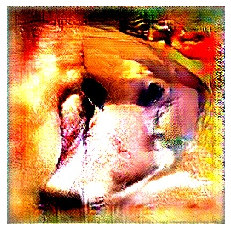

In [35]:
# Animal = "Beto"; Expi = 11
Animal = "Beto"; Expi = 11
exp_suffix = "_nobdr_alex"
netname = "alexnet"
corrDict = np.load(join("S:\corrFeatTsr","%s_Exp%d_Evol%s_corrTsr.npz"%(Animal,Expi,exp_suffix)), allow_pickle=True)#
cctsr_dict = corrDict.get("cctsr").item()
Ttsr_dict = corrDict.get("Ttsr").item()

ReprStats = loadmat(join(mat_path, Animal + "_ImageRepr.mat"), struct_as_record=False, squeeze_me=True, chars_as_strings=True)['ReprStats']
show_img(ReprStats[Expi-1].Manif.BestImg)

NMF explained variance 0.567
Predictability of the corr coef tensor 0.712


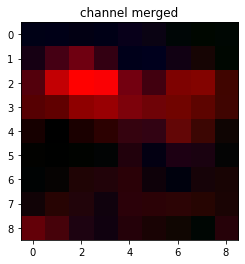

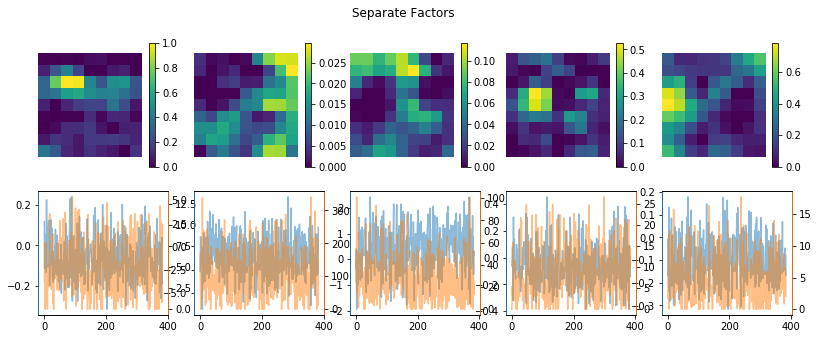

Factor0 norm 579.36
Factor1 norm 630.69
Factor2 norm 551.02
Factor3 norm 591.41
Factor4 norm 610.88


In [69]:
# layer = "conv4_3"
layer = "conv3"
bdr = 2
Ttsr = Ttsr_dict[layer]
cctsr = cctsr_dict[layer]
Ttsr_pp = rectify_tsr(Ttsr, "abs")#"mode="thresh", thr=(-5,5))
Hmat, Hmaps, Tcomponents_, ccfactor = tsr_factorize(Ttsr_pp, cctsr, bdr=bdr, Nfactor=5)

Now let's load up the network and Generator, visualize the contents for this neuron group / feature vector

In [5]:
if netname == "alexnet":
    net = models.alexnet(True)
    net.requires_grad_(False)
    featnet = net.features.cuda().eval()
elif netname == "vgg16":
    net = models.vgg16(pretrained=True)
    net.requires_grad_(False)
    featnet = net.features.cuda().eval()
else:
    raise ValueError

G = upconvGAN("fc6").cuda()
G.requires_grad_(False);

Visualize the feature vector without spatial structure, (full feature map)

D:\Github\Visual_Neuron_Modelling\CorrFeatTsr_visualize.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight_tsr[layer] = torch.tensor(weight).float().cuda()
step 6, score 139.79 128.14 133.13 144.51:   4%|▍         | 4/100 [00:00<00:02, 38.39it/s]

Feature Correlator Destructed, Hooks deleted.


step 99, score 524.48 609.34 652.18 645.64: 100%|██████████| 100/100 [00:02<00:00, 44.19it/s]


Final scores 652.18 645.64 609.34 524.48


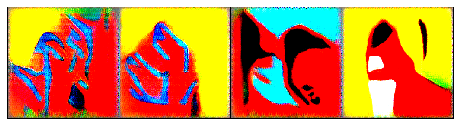

step 99, score 2429.63 2254.64 2581.99 2417.51: 100%|██████████| 100/100 [00:02<00:00, 44.65it/s]


Final scores 2581.99 2429.63 2417.51 2254.64


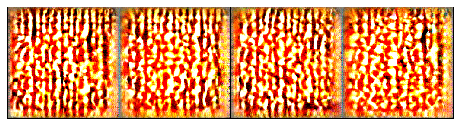

step 99, score 282.02 275.21 284.99 284.18: 100%|██████████| 100/100 [00:02<00:00, 44.90it/s]


Final scores 284.99 284.18 282.02 275.21


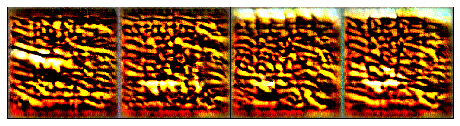

step 99, score 212.43 224.85 194.06 238.01: 100%|██████████| 100/100 [00:02<00:00, 44.87it/s]


Final scores 238.01 224.85 212.43 194.06


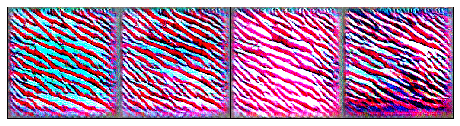

step 99, score 75.52 72.58 63.48 79.27: 100%|██████████| 100/100 [00:02<00:00, 44.73it/s]


Final scores 79.27 75.52 72.58 63.48


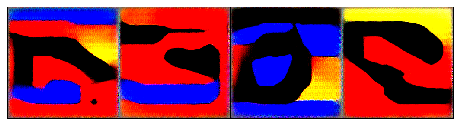

In [52]:
scorer = CorrFeatScore()
scorer.register_hooks(net, layer, netname=netname)
for ci in range(ccfactor.shape[1]):
    fact_W = torch.from_numpy(ccfactor[:, ci]).reshape([-1,1,1])
    scorer.register_weights({layer: fact_W.unsqueeze(0)})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, featnet, preprocess, layername=layer, lr=0.025, MAXSTEP=100,
                              imshow=True, verbose=False, adam=True)
scorer.clear_hook()

Visualize the feature vector times the spatial mask from regressing the correlation tensor, (structured feature map)

Feature Correlator Destructed, Hooks deleted.


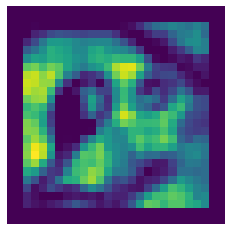

step 99, score 0.17 0.24 0.26 0.21: 100%|██████████| 100/100 [00:02<00:00, 44.27it/s]


Final scores 0.26 0.24 0.21 0.17


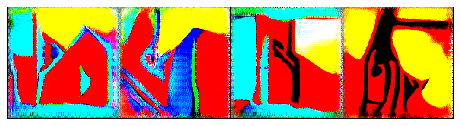

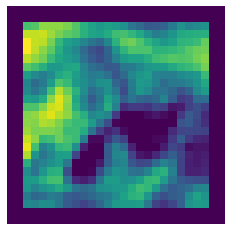

step 99, score 0.61 0.60 0.61 0.61: 100%|██████████| 100/100 [00:02<00:00, 44.77it/s]


Final scores 0.61 0.61 0.61 0.60


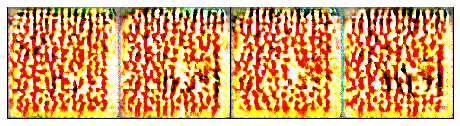

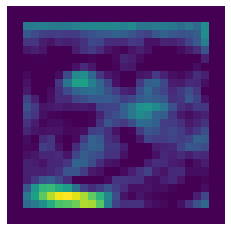

step 99, score 0.09 0.08 0.08 0.08: 100%|██████████| 100/100 [00:02<00:00, 44.84it/s]


Final scores 0.09 0.08 0.08 0.08


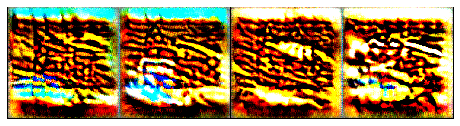

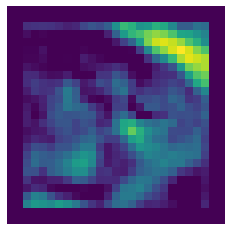

step 99, score 0.11 0.12 0.11 0.12: 100%|██████████| 100/100 [00:02<00:00, 44.74it/s]


Final scores 0.12 0.12 0.11 0.11


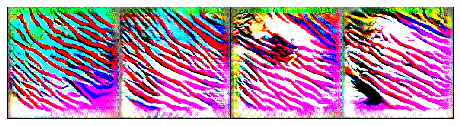

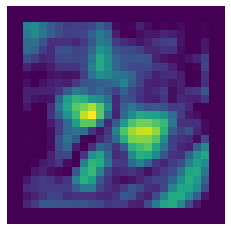

step 99, score 0.04 0.04 0.04 0.04: 100%|██████████| 100/100 [00:02<00:00, 44.73it/s]


Final scores 0.04 0.04 0.04 0.04


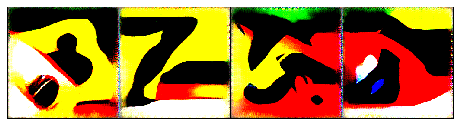

In [38]:
scorer = CorrFeatScore()
scorer.register_hooks(net, layer, netname=netname)
for ci in range(ccfactor.shape[1]):
    padded_mask = np.pad(Hmaps[:,:,ci:ci+1], ((bdr,bdr),(bdr,bdr),(0,0)),mode="constant")
    fact_Wtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, ci:ci+1], padded_mask))
    show_img(padded_mask[:,:,0])
    scorer.register_weights({layer: fact_Wtsr})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, featnet, preprocess, layername=layer, lr=0.1, MAXSTEP=100, imshow=True, verbose=False)
scorer.clear_hook()

Visualize the feature vector at the center of the feature map, (structured feature map)

step 7, score 0.19 0.30 0.36 0.31:   4%|▍         | 4/100 [00:00<00:02, 39.32it/s]

Feature Correlator Destructed, Hooks deleted.


step 99, score 3.29 1.66 3.36 3.07: 100%|██████████| 100/100 [00:02<00:00, 44.65it/s]


Final scores 3.36 3.29 3.07 1.66


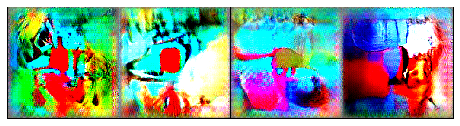

step 99, score 8.65 10.17 10.10 8.71: 100%|██████████| 100/100 [00:02<00:00, 44.66it/s]


Final scores 10.17 10.10 8.71 8.65


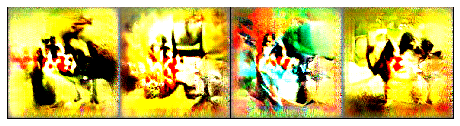

step 99, score 1.58 1.58 1.86 1.61: 100%|██████████| 100/100 [00:02<00:00, 44.91it/s]


Final scores 1.86 1.61 1.58 1.58


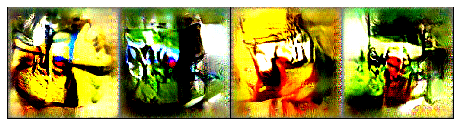

step 99, score 0.88 0.91 0.76 0.75: 100%|██████████| 100/100 [00:02<00:00, 44.82it/s]


Final scores 0.91 0.88 0.76 0.75


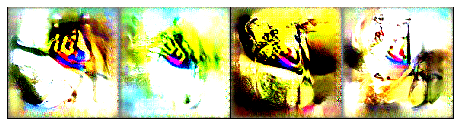

step 99, score 0.31 0.28 0.16 0.35: 100%|██████████| 100/100 [00:02<00:00, 44.79it/s]


Final scores 0.35 0.31 0.28 0.16


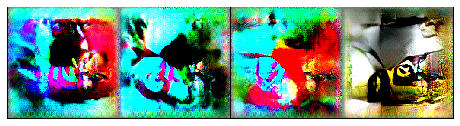

In [39]:
scorer = CorrFeatScore()
scorer.register_hooks(net, layer, netname=netname)
for ci in range(ccfactor.shape[1]):
    H,W,_ = Hmaps.shape
    sp_mask = np.pad(np.ones([2,2,1]), ((H//2-1+bdr,H-H//2-1+bdr),(W//2-1+bdr, W-W//2-1+bdr),(0,0)),mode="constant",
                     constant_values=-0.000)
    # show_img(sp_mask[:,:,0])
    fact_Chtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, ci:ci+1], sp_mask))
    scorer.register_weights({layer: fact_Chtsr})
    finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, featnet, preprocess, layername=layer, lr=0.05, MAXSTEP=100,
                          imshow=True, verbose=False)
scorer.clear_hook()

Next let's test, if we have a model neuron with these 3 components can we recreate the original prototype through
evolution / Gradient optimization?

step 5, score -0.03 -0.02 -0.02 -0.02 -0.02:   3%|▎         | 4/150 [00:00<00:04, 33.99it/s]

Feature Correlator Destructed, Hooks deleted.


step 149, score 0.31 0.31 0.34 0.29 0.30: 100%|██████████| 150/150 [00:03<00:00, 39.05it/s] 


Final scores 0.34 0.31 0.31 0.30 0.29


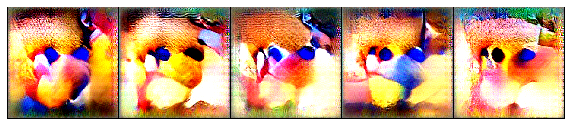

In [50]:
padded_mask = np.pad(Hmaps[:,:,:], ((bdr,bdr),(bdr,bdr),(0,0)), mode="constant")
DR_Wtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, :], padded_mask))
scorer = CorrFeatScore()
scorer.register_hooks(net, layer, netname=netname)
scorer.register_weights({layer: DR_Wtsr}) #DR_Wtsr
finimgs, mtg, score_traj = corr_GAN_visualize(G, scorer, featnet, preprocess, layername=layer, lr=0.02,
      MAXSTEP=150, imshow=True, verbose=False, langevin_eps=0.03, Bsize=5)
scorer.clear_hook()

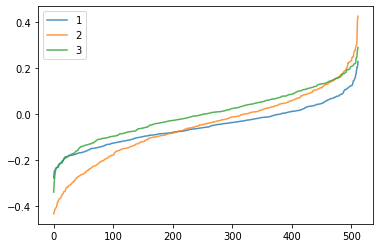

In [33]:
plt.plot(np.sort(ccfactor,axis=0), alpha=0.8)
plt.legend([1,2,3])
plt.ylabel("")
plt.show()

In [24]:
from data_loader import load_score_mat, loadmat, mat_path
from CorrFeatTsr_lib import visualize_cctsr, visualize_cctsr_embed, Corr_Feat_Machine, Corr_Feat_pipeline, loadimg_preprocess, loadimg_embed_preprocess
from tqdm import tqdm
from scipy.optimize import curve_fit

def score_images(featNet, scorer, layername, imgfps, imgloader=loadimg_preprocess, batchsize=40,):
    imgN = len(imgfps)
    csr = 0
    pbar = tqdm(total=imgN)
    score_all = []
    while csr < imgN:
        cend = min(csr + batchsize, imgN)
        input_tsr = imgloader(imgfps[csr:cend], borderblur=True)  # imgpix=120, fullimgsz=224
        with torch.no_grad():
            part_tsr = featNet(input_tsr.cuda()).cpu()
            score = scorer.corrfeat_score(layername)
        score_all.append(score.detach().clone().cpu())
        pbar.update(cend - csr)
        csr = cend
    pbar.close()
    score_all = torch.cat(tuple(score_all), dim=0)
    return score_all

def softplus(x, a, b, thr):
    return a * np.logaddexp(0, x - thr) + b

def fit_predscore(pred_score_np, score_vect):
#     pred_score_np = pred_score.numpy()
    scaling = 1/pred_score_np.std()*score_vect.std()
    pred_score_np_norm = pred_score_np * scaling
    popt, pcov = curve_fit(softplus, pred_score_np_norm, score_vect, \
          p0=[1, min(score_vect), np.median(pred_score_np_norm)], \
          bounds=([0, 0, min(pred_score_np_norm)-10], [np.inf, max(score_vect), max(pred_score_np_norm)]))
    print("amp %.1e baseline %.1e thresh %.1e"%tuple(popt))
    nlpred_score = softplus(pred_score_np_norm, *popt)
    plt.figure(figsize=[8,4.5])
    plt.subplot(121)
    plt.scatter(pred_score_np, nlpred_score, alpha=0.6, label="fitting")
    plt.scatter(pred_score_np, score_vect, alpha=0.6, label="data")
    plt.xlabel("Factor Prediction")
    plt.ylabel("Original Scores")
    plt.title("Before Fitting corr %.3f"%(np.corrcoef(score_vect, pred_score_np)[0, 1]))
    plt.legend()
    plt.subplot(122)
    plt.scatter(nlpred_score, score_vect)
    plt.axis("image")
    plt.xlabel("Factor Prediction + nl")
    plt.ylabel("Original Scores")
    plt.title("After Fitting corr %.3f"%(np.corrcoef(score_vect, nlpred_score)[0, 1]))
    plt.show()
    return popt, pcov, scaling, nlpred_score

In [9]:
MStats = loadmat(join(mat_path, Animal + "_Manif_stats.mat"), struct_as_record=False, squeeze_me=True)['Stats']
EStats = loadmat(join(mat_path, Animal + "_Evol_stats.mat"), struct_as_record=False, squeeze_me=True, chars_as_strings=True)['EStats']
score_vect, imgfullpath_vect = load_score_mat(EStats, MStats, Expi, "Manif_avg", wdws=[(50, 200)], stimdrive="S")

  0%|          | 0/121 [00:00<?, ?it/s]

Feature Correlator Destructed, Hooks deleted.


100%|██████████| 121/121 [00:00<00:00, 136.93it/s]


Predict ~ score Corr 0.826
amp 1.8e+00 baseline 2.0e-01 thresh -5.8e-01


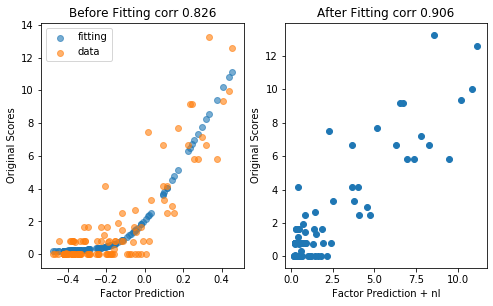

In [25]:
padded_mask = np.pad(Hmaps[:,:,:], ((bdr,bdr),(bdr,bdr),(0,0)), mode="constant")
DR_Wtsr = torch.from_numpy(np.einsum("ij,klj->ikl", ccfactor[:, :], padded_mask))

scorer = CorrFeatScore()
scorer.register_hooks(net, layer, netname=netname)
scorer.register_weights({layer: DR_Wtsr})
pred_score = score_images(featnet, scorer, layer, imgfullpath_vect, imgloader=loadimg_preprocess, batchsize=40,)
scorer.clear_hook()
cc = np.corrcoef(score_vect, pred_score.numpy())[0, 1]
print("Predict ~ score Corr %.3f"%cc)

popt, pcov, scaling, nlpred_score = fit_predscore(pred_score.numpy(), score_vect)
# plt.scatter(pred_score.numpy(), score_vect, alpha=0.7)
# plt.xlabel("Factor Prediction")
# plt.ylabel("Original Scores")
# plt.title("Correlation %.3f"%(np.corrcoef(score_vect, pred_score.numpy())[0, 1]))
# plt.show()


Factorized model reproduce this prediction.

In [31]:
from FactorModels_lib import FactorRegr_Machine, predict_cmp
fact_model = FactorRegr_Machine(Nfactor=ccfactor.shape[1], batchnorm=True, spatial_nonneg=True)
fact_model.register_hooks(net, [layer], netname=netname)
fact_model.init_model(img_dim=224, borderclip=bdr)

100%|██████████| 121/121 [00:01<00:00, 85.32it/s]


 Summary
Layer conv4: Corr 0.890 MSE 1543469.000


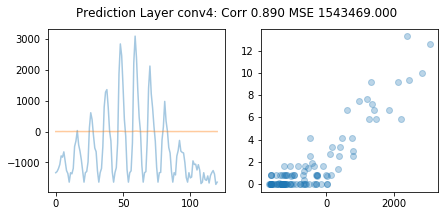

In [32]:
sp_weight = torch.from_numpy(np.transpose(Hmaps, [2,0,1]).reshape([1,-1])).float().cuda()
feat_weight = torch.from_numpy(ccfactor.T).unsqueeze(2).unsqueeze(3).float().cuda()

fact_model.feat_trans[layer].weight.data = feat_weight
fact_model.feat_trans[layer].bias.data.zero_()
fact_model.sp_mask[layer].weight.data = sp_weight
fact_model.sp_mask[layer].bias.data.zero_()
fact_model.bn_layer[layer].eval()

pred_scores = predict_cmp(featnet, fact_model, torch.from_numpy(score_vect).float(), imgfullpath_vect,
                          imgloader=loadimg_preprocess, batchsize=35, summarystr="")

Do a nonlinear fit to

In [ ]:
# Use pseudo inverse to compute the regression factors along the channel dimension.
np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]

In [ ]:
mode = "abs"#"thresh"#pos_rect
thr = (-4,4)
layer = "conv4_3"
bdr = 2
Ttsr = Ttsr_dict[layer]
cctsr = cctsr_dict[layer]
Ttsr_pp = rectify_tsr(Ttsr, mode="thresh", thr=thr)
C, H, W = Ttsr_pp.shape
if bdr == 0:
    Tmat = Ttsr_pp.reshape(C, H*W)
    ccmat = cctsr.reshape(C, H*W)
else:
    Tmat = Ttsr_pp[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
    ccmat = cctsr[:, bdr:-bdr, bdr:-bdr].reshape(C, (H-2*bdr)*(W-2*bdr))
#%
nmfsolver = NMF(n_components=3, init="nndsvda", solver="cd")#mu
Hmat = nmfsolver.fit_transform(Tmat.T)
Hmaps = Hmat.reshape([H-2*bdr, W-2*bdr, 3])
exp_var = 1-npnorm(Tmat.T-Hmat@nmfsolver.components_)/npnorm(Tmat)
print("NMF explained variance %.3f"%exp_var)
plt.imshow(Hmaps / Hmaps.max())
plt.title("channel merged")
plt.show()
[figh, axs] = plt.subplots(1,3,figsize=[9, 2.5])
for ci in range(Hmaps.shape[2]):
    plt.sca(axs[ci])
    plt.imshow(Hmaps[:,:,ci] / Hmaps.max())
    plt.axis("off")
    plt.colorbar()
plt.suptitle("Separate Factors")
plt.show()

ccfactor = (ccmat @ np.linalg.pinv(Hmat).T )
# ccfactor = (ccmat @ Hmat )
np.corrcoef((ccfactor@Hmat.T).flatten(), ccmat.flatten())[0,1]

featvecs = nmfsolver.components_
fact_norms = []
for i in range(Hmaps.shape[2]):
    rank1_mat = Hmat[:, i:i+1]@featvecs[i:i+1, :]
    matnorm = npnorm(rank1_mat, ord="fro")
    fact_norms.append(matnorm)
    print("Factor%d norm %.2f"%(i, matnorm))

In [303]:
# reshape to channel by space

# NMF factorize

# Reshape spatial factors

# Normalize spatial factors

# visualize plot 3 channel plot

0.8496500967486587